<span style="font-size:2em">Comparison of imputation methods, using deep learning structures and classical ones</span> 

**Occhipinti Mathieu, Maasai Inria**

# Introduction 

## Purpose of the notebook 


This notebook aims to provide a brief overview of different imputation methods. 

In the last year, several imputers using deep learning structures have been implemented and claim to have better performances than former state of the art imputation procedure.

We will explain the procedure behind each method (without giving too much mathematical details) and then we will compare them.
Lastly, we will study the importance of standardization for deep learning based procedures

## Imputation methods

Here is a list of the different methods we will study :

* `MIDA` (Multiple Imputation using Denoisive autoencoder) proposed by Lovedeep Gondara ande Wang (2018) in the article [MIDA](https://arxiv.org/abs/1705.02737) and using the Python's package [MIDASpy](https://github.com/MIDASverse/MIDASpy)

* `MIWAE` (Missing data importance-weighted autoencoder) proposed by Pierre-Alexandre Mattei and Jes Frellsen (2019) in the article [MIWAE](https://arxiv.org/abs/1812.02633) and implemented in [Github MIWAE](https://github.com/pamattei/miwae).

* `missForest` : The method implemented in [Scikit learn](https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html) and inspired by the [article](https://academic.oup.com/bioinformatics/article/28/1/112/219101?login=true) of Daniel J.Stekhoven and Peter Bühlmann (2011).

* `Mean` : The classical mean method for imputing missing values

#  Load the packages

 First we need to create datasets on which we will be able to compare our imputation methods


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import os

class TensorFlowLogger:
    def __init__(self):
        self.logger = logging.getLogger('tensorflow')
        self.logger.setLevel(logging.WARNING)
        self.logger.addHandler(logging.FileHandler(os.path.join(os.getcwd(), 'tensorflow.log')))

    def set_log_level(self, level):
        self.logger.setLevel(level)

    def get_log_level(self):
        return self.logger.level

    def log(self, message, level=logging.INFO):
        if self.logger.isEnabledFor(level):
            self.logger.log(level, message)

logger = TensorFlowLogger()
logger.set_log_level(logging.ERROR)

import tensorflow as tf

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import MinMaxScaler


# For MIDA

import MIDASpy as md


# For MIWAE

import torch
import torchvision
import torch.nn as nn
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import torch.distributions as td

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

C:\Users\mathi\anaconda3\envs\deep-occhipinti-env\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Using gpu: False 


# Create a complete dataset

## Complete dataset in Python

In this part, a complete dataset $X \in \mathbb{R}^{n\times c}$ is generated. Different models can be chosen: 

* **linear relation** between the covariates. More particularly, 

    * we generate $(x_1,x_2) \sim \mathcal{N}(\mu,\Sigma)$, with $x_1,x_2 \in \mathbb{R}^n$.
    * $X = [x_1,\dots,x_1,x_2,\dots,x_2] + \epsilon,$ with $\epsilon \sim \mathcal{N}(0,\sigma^2 I_{c\times c})$. The $k$ first columns are $x_1+\mathrm{noise}$ and the $c-kc$ last columns are $x_2+\mathrm{noise}$.
    
* **non-linear relation** between the covariates. 

    * $\forall j \in \{1,\dots,c\}$, the column $j$ of $X$ is such that $X_{.j}=\sin\left(f_n\left(2\pi\frac{(j-1)}{c} + u_n\right)\right)+\epsilon_{.j}$,
    with $u_n \sim \mathcal{U}[0;2\pi]$ (uniform law) and $f_n$ is fixed and chosen by the user.
    
The function in Python **create_complete_dataset** allows to create a complete dataset $X$ in such ways. The arguments are detailed as follows

* `seed`: seed to reproduct the simulations.

* `n`: number of observations in $X$.

* `c`: number of covariates in $X$. 

* `noise`: variance of the noise $\epsilon$.

* `modSimu`: "linear" or "non-linear".

* `k` $\in \lbrack 0,1 \rbrack $: if `modSimu="linear"`, it is the percentage of columns that are equals to x1.

* `mu`: if `modSimu="linear"`, the mean vector of $(x_1,x_2)$.

* `Sigma`: if `modSimu="linear"`, the covariance matrix of $(x_1,x_2)$.

* `fn`: if `modSimu="non-linear"`, the scale-parameter to use.

In [3]:
def create_complete_dataset(seed,n,c,noise,modSimu,k=None,mu=None,Sigma=None,fn=None):
    if (modSimu=="linear"):
        X=np.random.multivariate_normal(size=n,mean=mu,cov=Sigma)
        tab=np.empty((n,c))
        for i in range (c):
            if i<np.around(k*c):
        
                tab[:,i]=X[:,0]
            else :
                tab[:,i]=X[:,1]
        tab+=np.array(np.random.normal(loc=0,scale=noise,size=(n,c)))

    elif (modSimu=="non-linear"):
        un=np.random.uniform(low=0,high=2*np.pi,size=n)
        tab=np.empty((n,c))
        for i in range(c) :
            tab[:,i]=np.sin(fn*((2*np.pi*i/c+un)))
        tab+=np.array(np.random.normal(loc=0,scale=noise,size=(n,c)))
    return tab
        

        
        

We can then create a dataset, let set the parameters in the following cell

In [4]:
## Dataset parameters

seed=641
n=250
c=7
modSimu="linear"
k=0.4
mu=[1,1]
Sigma=np.array([[1,0.1],[0.1,1]])


data=pd.DataFrame(create_complete_dataset(seed=seed,n=n,c=c,modSimu=modSimu,k=k,mu=mu,Sigma=Sigma,noise=0.6))


## Standardization of our data

We want to standardize our data. To do so, we use the simple trick which is substraying the mean and divide by the standard deviation each individual column of our original frame

In [4]:
standardized_data = (data - np.mean(data,0))/np.std(data,0)


# Introduce Missing values

To introduce missing values, we use the function **missing_method** whose principles are provided by the MIDA's [article](https://arxiv.org/abs/1705.02737). It allows us to add missing values following a MCAR or MAR mechanism, whether we want the unaivability of the data to do not depend on the data values (MCAR) or depend on the values of the observed variables (MAR). 



The function **missing_method** has the following arguments:

* `raw_data`: our complete dataset.

* `mechanism`: type of the process which causes the lack of data: "mcar" or "mar".

* `t`: proportion of missing values to introduce.

In [5]:
from missing_mechanism import *

In [6]:
def missing_method(raw_data, mechanism='mcar',t=0.2) :
    
    data = raw_data.copy()
    rows, cols = data.shape
    
    # missingness threshold
    
    if mechanism == 'mcar' :
        # uniform random vector
        v = np.random.uniform(size=(rows, cols))

        # missing values where v<=t 
        # mask is a matrix where mij equals to True if vij<=t and False otherwise
        mask = (v<=t)
        data[mask] = np.nan


        
    
    elif mechanism == 'mar' :
        nump=raw_data.to_numpy()
        mask=MAR_mask(X=nump,p=t,p_obs=0.0)
        data[mask]=np.nan

    elif mechanism=="mnar":
        nump=raw_data.to_numpy()
        mask=MNAR_self_mask_logistic(nump,p=t)
        data[mask]=np.nan
    else :
        print("Error : There is no such mechanism")
        raise
    return data, ~mask

We can create a data with missing missing values (mar or mcar) and also a binary matrix indicating if a value is missing or not (value is at zero if missing, one otherwise)

In [9]:
miss,mask=missing_method(raw_data=data,mechanism="mnar",t=0.8)
print(miss.isna().sum())


0    208
1    198
2    192
3    200
4    194
5    210
6    190
dtype: int64


# MIDA algorithm

## Overview

The MIDA model is based on what we called a denoising autoencoder. Autoencoders are built to extract the important features of an input. Denoising autoencoders are an extension of those and aim to extract the important features of the data which also have the property of being robust to partial destruction of the input, called the corruption. Thus, the missing data can be considered as a corruption of the original data for our denoising autoencoder.

The goal of the method is to train a denoising autoencoder to learn from an incomplete dataset, the most robust features and then reconstruct a complete dataset based on the learning. 

This process is already implemented in the python package name MIDASpy. In the following, we will describe the main function and how to use it and then compare it with other imputation method in an other section.




## How to impute with MIDASpy package 

All this package is the work of Lall, Ranjit, and Thomas Robinson (2023) and can be found on this [Github Repository](https://github.com/MIDASverse/MIDASpy)

### Initialization of the MIDA network with the **Midas()** function


Here are the main hyperparameters for the initialization and what you need to know about them.

* `layer_structure` : a list of integers which defines our network structure. For instance [256,256,256] denotes a three layers network with 256 nodes for each layer. But be careful, while larger networks can learn more complex data structures, they also increase the training time and are more likely to overfit the data.

* `learn_rate` : the learning rate called $\gamma$ controls the size of the adjustments to weights and biases in each training epochs. A higher value of the learning rate might hasten the training procedure but can lead to a loss of accuracy

* `input_drop` : $\in \lbrack 0,1 \rbrack$, What is it exactly ?, A higher value will increase training time but prevent overfitting. Empirically, values between $0.7$ and $0.95$ give the better trade-off between speed and accuracy

* `train_batch` : To complete

* `seed` : An integer to which Python's pseudo-random generator are set to make reproductible results.

Other parameters are available for this function but are not at interest for us, check the  [MIDASpy documentation](https://ranjitlall.github.io/assets/pdf/jss4379.pdf) for more informations.

In [8]:
## Hyperparameters

## Layer structure of our network

la_str= [64,64,64] 

## Learning rate

lr=0.0001

## Input drop 

in_d=0.8

## Size of the training batches

tr_b=32

## Seed for pseudo-random generator

seed=756

## Initializing our Mida imputer 

Midas_imputer=md.Midas(layer_structure=la_str,input_drop=in_d,train_batch=tr_b,seed=seed)




### Build our imputation model with the **.build_model()** function

Here are the main parameters for this function :

* `imputation_target` : a Dataframe which we want to impute values in.

* `verbose` : a boolean to specify whether to print a message in the terminal or not (True by default).

Other parameters are used to handle categorical variables. It is not at interest for us, but check [MIDASpy documentation](https://ranjitlall.github.io/assets/pdf/jss4379.pdf) for more informations

In [9]:
## Build our model

Midas_imputer.build_model(imputation_target=miss)


Size index: [7]

Computation graph constructed



### Train our model with the .**train_model()** function

Here are the main parameters for this function : 

* `training_epochs` : an integer which represents the number of complete passes through our network during the traininng (100 by default)

* `verbose` : a boolean to specify whether print messages on the terminal including loss values (True by default)

* `verbosity_ival ` : an integer that sets the number of training epochs between each message on our terminal (1 by default)

* `excessive` : a boolean that specifies if you want to print loss for each mini-batch (False by default)

In [10]:
## Parameters 

## Number of training epochs

tr_ep=300

## Verbose

vb=True

## Verbosity eval

vb_ival=30

## Excessive

exc=False

## Train our model

Midas_imputer.train_model(training_epochs=tr_ep,verbose=vb,verbosity_ival=vb_ival,excessive=exc)

Model initialised

Epoch: 0 , loss: 5.155133451734271
Epoch: 30 , loss: 5.180300985063825
Epoch: 60 , loss: 5.047234330858503
Epoch: 90 , loss: 5.213028975895473
Epoch: 120 , loss: 5.185971873147147
Epoch: 150 , loss: 5.0768295015607565
Epoch: 180 , loss: 5.043931143624442
Epoch: 210 , loss: 5.0938021796090265
Epoch: 240 , loss: 5.1642671312604636
Epoch: 270 , loss: 5.128938129970005
Training complete. Saving file...
Model saved in file: tmp/MIDAS


### Generate complete datasets with the **.generate_samples()** function 

Here are the main parameters for this function :

* `m` an integer that indicates the number of complete datasets (m=10 by default)

* `verbose` a boolean to specify whether you want messages printed in your terminal (True by default)

$\text{\color{red} Important thing to know}$ :

The m complete datasets are stored in **.output_list()** a list from which they can be easily accessed.

Nevertheless, when working with large datasets or limited RAM, you may want to use the **.yield_samples()** function. This function takes the same arguments as **.generate_samples()** but doesn't stored the m complete datasets in memory at the same time. Instead it returns a Python generator from which each dataset can be called sequentially. 





In [11]:
## Parameters

## The number of complete datasets you want

M= 5 

## Generate our complete datasets

Mida_imputations=Midas_imputer.generate_samples(m=M).output_list



INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.


# MIWAE algorithm 

## Overview

The MIWAE (Missing data importance-weighted autoencoder) method is based on variational autoencoder (VAE). Variational autoencoder is a kind of autoencoder which maps an imput to a distribution in place of a single point. In this method we trained a DLVM (deep latent variable model) to obtain distributions that would allow us to generate data with the information collected on the observed data. To impute with this method, we use self-normalized importance sampling (check [this course](https://artowen.su.domains/mc/Ch-var-is.pdf) by Art Owen).

For more details on the building of the model and the architecture used, refer to [MIWAE's article](https://arxiv.org/pdf/1812.02633.pdf) and to the [MIWAE's github page](https://github.com/pamattei/miwae) for more details about the implementation.

## How to impute with MIWAE methods

In order to keep this notebook clean, we will import a the **MIWAE.py** file which contains the implementation of the MIWAE procedure. All the code included in this file is extracted from the [MIWAE's Github page](https://github.com/pamattei/miwae) and can be found with more comprehensive informations.

In [7]:
## Import the MIWAE file that contains the relevant functions to build and train the MIWAE model

from MIWAE import *

### Descriptive of the functions with main parameters 

In the following section, we will make a comprehensive list of the functions contain in the **MIWAE.py** file with parameters for each.

#### The **mse()** function

The **mse()** function returns the Mean Squared error of your imputed data regarding the true data.

**Parameters** :

* `xhat` : your imputed dataset

* `xtrue` : your complete dataset

* `mask` : a binary matrix of the size of our dataset for which the value is zero if the value is missing in your incomplete dataset and one otherwise.

#### The **prior**() function 

The **prior()** returns the prior distribution of our latent variables of our DLVM model.

**Parameters**:

* `d` : dimension of the latent space of our DLVM.

* `device` : either **gpu** or **cpu** but chosen automatically by the notebook

#### The **miwae_loss()** function 

The **miwae_loss()** function computes the value of the loss function used in the MIWAE algorithm. We won't give the parameters for this one as it is only used during the training of the algorithm and won't be directly called in this notebook. 
However, the full implementation can be found in the **MIWAE.py** file. 

#### The **build_encoder_decoder()** function 

The **build_endoder_decoder()** function is used to create our encoder and decoder for our DLVM, a key part of of the MIWAE procedure.

**Parameters** :

* `p` : the number of features of our dataset

* `h` : the number of hidden units, same for all the MLP's (h=128 by default)

* `d` : the dimension of the latent space (d=1 by default)

#### The **build_optimizer()** function 

The **build_optimizer()** function returns the Adam optimizer of our model.

**Parameters** :

* `encoder` : the encoder of our model

* `decoder` : the decoder of our model



#### The **train_MIWAE()** function

The **train_MIWAE()** function trains our model to fit our data. It returns a list which contains the training mse of all the epochs that satisfy $\text{ep}\equiv 1 \lbrack 100\rbrack$. 

**Parameters**:

* `encoder` : the encoder of our model

* `decoder` : the decoder of our model

* `optimizer` : the optimizer of our model build with the **build_optimizer()** function

* `d` : the dimension of the latent space of our DLVM

* `p_z` : the prior distribution of our model build with the **prior()** function

* `miss_data` : an incomplete training dataset

* `raw_data` an complete training dataset in order to compute the training imputation mse.

* `device` : either **gpu** or **cpu** but it automatically chosen by this notebook

* `n_epochs` : number of epochs for the training (n_epochs=2002 by default)

* `bs` : the size of the batch to use for training (bs=64 by default)

* `K` : number of draw of the importance sampling used to build the MIWAE lower bound.

* `verbose` : a boolean to specify you want a message printed in your terminal or not (True by default)

#### The **miwae_multiple_impute()** function

The **miwae_multiple_impute()** function returns a list of M datasets that were imputed with the MIWAE method.

**Parameters**:

* `data` : an incomplete dataset to impute

* `encoder` : a train encoder of our model 

* `decoder` a train decoder of our model

* `d` : the dimension of the latent space

* `p` : the number of feature of our incomplete dataset

* `p_z` : the prior ditribution of our latent variable

* `M` : the number of dataset needed (M=10 by default)

### Steps for the imputation 

#### Step 1 : Define the hyperparameters of the model and retrieve the shape of our data

In [9]:
# Dimension of the latent space

d=1

# Number of layers for our MLP

h=128

# Number of draw of the importance sampling (used to build the MIWAE lower bound)

K=20

# Shape of our training data

n,p=miss.shape

#### Step 2 : Build the architecture of our model

In [10]:
## Build the prior 

p_z=prior(d=d,device=device)

## Build the decoder and encoder

encoder,decoder=build_encoder_decoder(p,h=h,d=d)

## Build the optimizer 

optimizer=build_optimizer(encoder=encoder,decoder=decoder)



#### Step 3 : Train our model of on our training dataset

In [ ]:
# Training of our model

mse_train=train_MIWAE(encoder=encoder,decoder=decoder,optimizer=optimizer,d=d,p_z=p_z,miss_data=miss,raw_data=X_train,device=device,K=K)


#### Step 4 : Generate multiple imputation of our validation dataset

In [ ]:
## Induce missingness in our validation dataset

miss_valid,mask_valid=missing_method(raw_data=X_Valid,mechanism="mcar",t=0.2)

## Retrieve the shape of our validation dataset

n_valid,p_valid=miss_valid.shape

## Select the number of complete dataset 

M_miwae=10

## Do the imputation and collect them in a list

miwae_imp=miwae_multiple_impute(data=miss_valid,encoder=encoder,decoder=decoder,d=d,p=p_valid,p_z=p_z,device=device,M=M_miwae)





# Miss Forest imputation

## Overview 

The missforest imputation lies on an random forest algorithm. The idea is to train a Random Forest model for a variable with the observed part depending of the other variable of the dataset and use the trained model to make the imputation of the missing values.

## Miss Forest imputation using **Scikit learn**

### Walkthrough

In [ ]:
missforest = IterativeImputer(max_iter=Rf_param[0], estimator=ExtraTreesRegressor(n_estimators=Rf_param[1]))
missf=miss.copy()
missforest.fit(missf)
xhat_mf = missforest.transform(missf)

# Mean imputation using 


## Overview

The mean imputation is one of the easiest method of imputation. It consists in replacing missing values in a column by the mean of the observed elements of the column. Nevertheless, this method shows poor performance in most cases and thus must be avoided. We include it here, to show that is very often not the best imputation method to use.

## Mean imputation using **Scikit learn**

### Walktrough

In [18]:
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
missm=miss.copy()
mean_imp.fit(missm)
xhat_mean = mean_imp.transform(missm)

# Comparison of the different methods

## Choose your dataset

In [12]:
## Choose the parameters of your dataset

# Seed for Python pseudo random generator

seed_comp=756

# Number of observations of your dataset

n_obs=300

# Number of covariates in your dataset

cov=4

# Variance of the noise 

var_noise=0.2

# The simulation of your dataset, either "linear" or "non-linear", refer to chapter 3 for the difference

mod_simu="non-linear"

# If you choose linear, specify :

# The percentage of values that are equals to x1

k_comp=0.5

# The mean of x1 and x2 as a vector

mu_comp=[3,7]

# The covariance matrix of x1 and x2 

Sigma_comp=np.array([[1,1],[1,4]])

# If you choose non-linear, specify :

# The scale parameter to use :

fn=4.8

## Create the dataset :

comp_data=pd.DataFrame(create_complete_dataset(seed=seed_comp,n=n_obs,c=c,modSimu=mod_simu,fn=fn,noise=var_noise))

## Standardize our data

std_comp_data=(comp_data - np.mean(comp_data,0))/np.std(comp_data,0)

### Choose which methods, missingness mechanism, percentage of NA to compare 



In [13]:
## Choose missingness mechanisms

list_mechanism=["mcar","mar","mnar"]

## Choose methods :
# "MIDA" for the Mida method introduced in chapter 5
# "MIWAE" for the Miwae method introduced in chapter 6
# "RF" for the random forest method introduced in chapter 7
# "MEAN" for the mean imputation method introduced in chapter 8

list_methods=["MIDA","MIWAE","RF","MEAN"]

## Choose the proportions of NA to introduce in the dataset

list_prop_NA=[0.1,0.2,0.3,0.4]

## Choose the number of versions for a each percentage of NA to do :

nb_simu=10

## Choose the number of multiple imputation for methods that allow it (MIWAE, MIDA):

M_comp=1000



## Choose the hyperparameters for the methods

It is important to notice that the hyperparameters for each method are to be chosen regarding the dataset you study.

Nevertheless, as they are many parameters for some methods and all don't have a huge impact on the model, we will only optimize a couple of parameters for each method).

In order to optmize a parameter we will test different values of this parameter and compare the imputation mse for a same incomplete dataset. This means that before optimizing parameters of each method, we first chose a mechanism (MAR,MCAR) and a proportion of missing values. This two thing (method and proportion) will be the same for all the parameters optimization

To reach this goal, we import the **optimization_tools.py** which contains three functions (one for each methods) that allows the user to optimize the relevant paramaters for MIDA, MIWAE and the RF methods.

In [8]:
from optimization_tools import *

### Incomplete dataset to use for optimizing the parameters

In [14]:
## We choose set missing values with a MCAR mechanism and 30% proportion 
miss_opti,mask_opti=missing_method(raw_data=std_comp_data,mechanism="mcar",t=0.3)

### MIDA Parameters

In [61]:
## For MIDA

# Layer structure of our network

la_str_MIDA= [64,64,64] 

# Learning rate

lr_MIDA=0.0028

# Input drop 

in_drop_MIDA=0.8

# Size of the training batches

tr_batch_MIDA=32

# Seed for pseudo-random generator

seed_MIDA=756

# Number of training epochs

tr_epochs_MIDA=100

MIDA_parameters=[la_str_MIDA,lr_MIDA,in_drop_MIDA,tr_batch_MIDA,seed_MIDA,tr_epochs_MIDA]

#### Choose the best hyperparameters 

We notice empirically that the different layer structure ([64,64,64],[128,128,128]) we use don't have a huge impact on the final result. The same for the other parameters except for the learning rate. Indeed, a too small learning rate alongside two little observations would result in poor results.


#### Optimize MIDA's learning rate 

The **optimize_MIDA_param()** function allows the user to choose the best learning rate for the MIDA method. It prints the best learning rate and also plot the mse as a function of the learning rate.

**Parameters**:

* `lr_array` : An array containing the the values of the learning rate you want to test.

* `full_data` : A complete dataset you are doing imputation on

* `miss_data` ; an incomplete dataset

* `mask` : the mask (a matrix of 0 and 1 depending on whether the value is missing or not) 

In [25]:
## Choose a set of learning rate to test

lr_opti=np.linspace(0.005,0.0005,50)
 

The minimum mse value is obtained for a learning rate : 0.0028


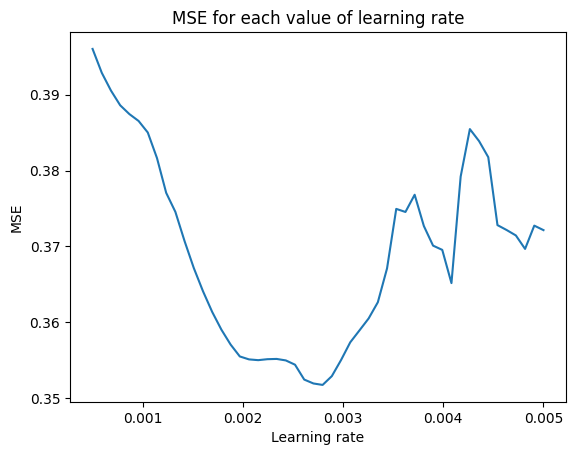

In [33]:
optimize_MIDA_param(lr_array=lr_opti,full_data=std_comp_data,miss_data=miss_opti,mask=mask_opti)

### MIWAE Parameters

In [60]:
## For Miwae

# Dimension of the latent space

d=3

# Number of layers for our MLP

h=64

# Number of draw of the importance sampling (used to build the MIWAE lower bound)

K=10

# Number of training epochs

tr_Miwae=100

MIWAE_parameters=[d,h,K,tr_Miwae]

#### Optimize MIWAE's latent space dimension and K parameters 

The **optimize_MIWAE_param()** functions allows the user to choose the best dimension space of latent space of our DLVM and also the number of iteration for the importance sampling of the MIWAE bound construction, it also plots the mse as a function of both separately.
For simplicity sake, we first optimize **d** using an arbitrary **K** (K=100 in our function). Then we optimize **K** using the optimal **d** finds in the first part.

**Parameters**:

* `d_array` : an array containing the the values of the dimension of the latent space you want to test.

* `K_array` : an array containing the the values of the number of iteration for the importance sampling of the MIWAE bound construction you want to test.

* `full_data` : a complete dataset you are doing imputation on

* `miss_data` ; an incomplete dataset

* `mask` : the mask (a matrix of 0 and 1 depending on whether the value is missing or not) 



In [22]:
## Choose the value of K and d to test

d_arr=np.linspace(1,10,10)
K_arr=np.linspace(10,150,15)


The minimum mse value is obtained for a dimension of the latent space d: 3 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


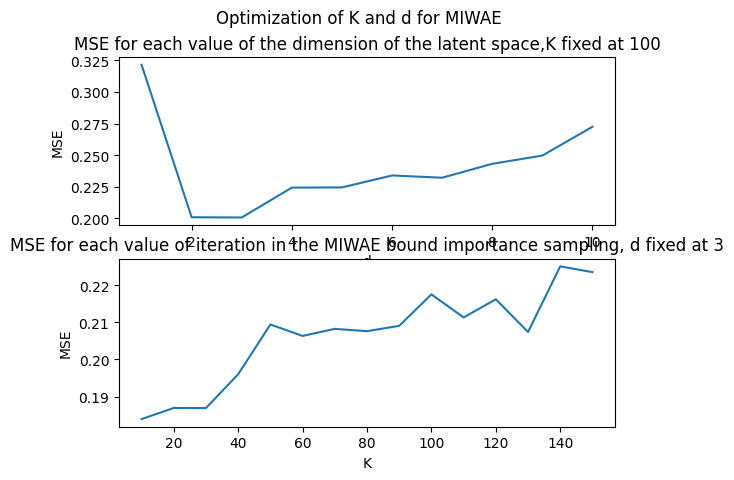

In [24]:
optimize_MIWAE_param(d_array=d_arr,K_array=K_arr,full_data=std_comp_data,miss_data=miss_opti,mask=mask_opti)

### Random Forest parameters

In [59]:
## For random forest

# Maximum number of iterations 

max_iter=10

# Number of estimators 

n_estimators=28

RF_parameters=[max_iter,n_estimators]


#### Optimize the RF's number of trees in the forest 

The **optimize_RF_param()** function allows the user to choose the best number of trees in the forest, it also plots the mse as a function of the previous parameter.

**Parameters**:

* `n_est_array` : an array containing the the values of the number of trees in the forest you want to test.

* `full_data` : a complete dataset you are doing imputation on

* `miss_data` ; an incomplete dataset

* `mask` : the mask (a matrix of 0 and 1 depending on whether the value is missing or not) 




In [55]:
## Choose the set of parameters to test

n_est=np.linspace(1,50,50)


The minimum mse value is obtained for a number of trees in the forest: 28.0


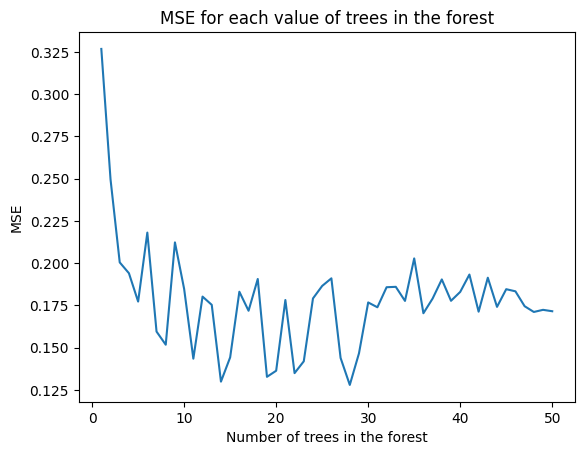

In [58]:
optimize_RF_param(n_est_array=n_est,full_data=std_comp_data,miss_data=miss_opti,mask=mask_opti)

## Compare the methods

We import the python files **comparison_tools**, **plot_tools** which contains two functions, one who is going to compute the mse for each methods, each percentage of NA and returns a dataframe with the informations. The other one allows the user to plot the results.

In [16]:
from comparison_tools import *
from plot_tools import *

## Brief description of the function

### The **comparison()** function

This functions returns two dictionnaries whose keys are the missingness mechanism (MAR, MCAR, MNAR). For the first one, the values are dataframes which contain the mean value of mse over all the simulation for each method and each percentage of NA and the results can be plot using the **plot_result()** function. For the second one, the values are dataframes which contain a list of mse values (one for each simulation done) for each method and each percentage of NA values and the results can be used to plot boxplots using the **boxplots_results()** function.

**Parameters** :

* `full_data` : a complete dataset

* `missing_mecha` : a list of the missingness mechanism you want to compare

* `prop_NA` : a list of different proportion of NA ($\in \lbrack 0,1 \rbrack$) you want MSE value for

* `comp_methods` : a list of the method you want to compare (Mean, Miwae, etc)

* `nb_simu` : an integer to specify the number of simulations you want for each percentage of NA (10 by default)

* `M` : an integer to specify the number of multiple imputations for methods that allows it (MIWAE,MIDA)

* `device` : the device is automatically chosen at the beginning of the notebook

* `Mida_param` : the list of parameters to run the MIDA algorithm, $\text{\color{red}please use the order given is the above example}$.

* `Miwae_param` : same as Mida_param but for MIWAE

* `Rf_param` : same as the two above

* `save` : a boolean that if specifies if you want the result dataframe(s) saved (False by default)

They will be saved in the current directory as "MAR_results.csv" and/or "MCAR_results" and/or "MNAR_results", "MAR_boxplot_results.csv" and/or for "MCAR_boxplot_results.csv".

To load them, please use the following : pd.read_csv(your_path,index_col=0)

### Tools to plot the results

#### The **plot_result()** function

This function prints one, two or three plots (depending on the number of mechanism you want to compare) reprensenting the mse as a function of the percentage of NA values for each methods chosen.

**Parameters**

* `results` : a dictionnary as returns by the **comparison()** function

* `comp_meth` : the list of methods that were compared

* `save` : a boolean indicating whether you want to save the results in a file (False by default). If true the file will be saved in the current directory.

* `name ` : If save=True, the name is mandatory. It is simply the name of the file that will be created thnaks to the function.

$\text{\color{red}Don't forget the format extension (.pdf, .jpg,...) depending on the format you want}$

#### The **boxplot_results()**

This function prints one, two or three plots (depending on the number of mechanism you want to compare) reprensenting the boxplot of the mse as a function of the percentage of NA values for each methods.

**Parameters**

* `results` : a dictionnary as returns by the **comparison()** function

* `comp_meth` : the list of methods that were compared

* `prop_l` : the list of proportions of NA values you tested during your comparison

* `mech` : the list of mechanism you tested during your comparison

* `save` : a boolean indicating whether you want to save the results in a file (False by default). If true the file will be saved in the current directory.

* `name ` : If save=True, the name is mandatory. It is simply the name of the file that will be created thnaks to the function.

$\text{\color{red}Don't forget the format extension (.pdf, .jpg,...) depending on the format you want}$

# Experiment

## Non linear case

In [159]:
seed_1=1456
n_1=300
cov_1=8
var_1=0.3
mod_1="non-linear"
k_1=0.5
mu_1=[3,7]
fn_1=4.2
Sigma_1=np.array([[1,0.1],[0.1,1]])
exp_1=pd.DataFrame(create_complete_dataset(seed=seed_1,n=n_1,c=cov_1,modSimu=mod_1,fn=fn_1,noise=var_1))
X_1=(exp_1 - np.mean(exp_1,0))/np.std(exp_1,0)
cor=X_1.corr()
print(cor)

          0         1         2         3         4         5         6   
0  1.000000 -0.842637  0.821085 -0.770436  0.713852 -0.624077  0.526897  \
1 -0.842637  1.000000 -0.859818  0.802717 -0.778813  0.707651 -0.633171   
2  0.821085 -0.859818  1.000000 -0.857932  0.806263 -0.782050  0.722881   
3 -0.770436  0.802717 -0.857932  1.000000 -0.854551  0.830351 -0.766208   
4  0.713852 -0.778813  0.806263 -0.854551  1.000000 -0.850788  0.818788   
5 -0.624077  0.707651 -0.782050  0.830351 -0.850788  1.000000 -0.831670   
6  0.526897 -0.633171  0.722881 -0.766208  0.818788 -0.831670  1.000000   
7 -0.413352  0.512513 -0.620131  0.709072 -0.777918  0.804864 -0.831508   

          7  
0 -0.413352  
1  0.512513  
2 -0.620131  
3  0.709072  
4 -0.777918  
5  0.804864  
6 -0.831508  
7  1.000000  


In [160]:
opti_test,mask_test=missing_method(raw_data=X_1,mechanism="mcar",t=0.3)

The minimum mse value is obtained for a learning rate : 0.0017


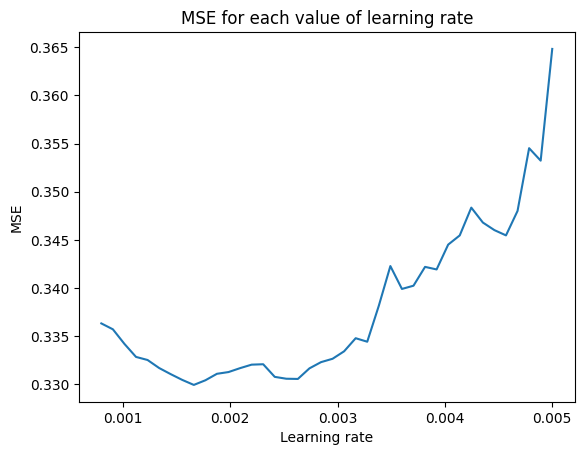

In [165]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0008,40),full_data=X_1,miss_data=opti_test,mask=mask_test)

The minimum mse value is obtained for a dimension of the latent space d: 4 and a number of iteration for the importance sampling of the MIWAE bound construction K :20.0


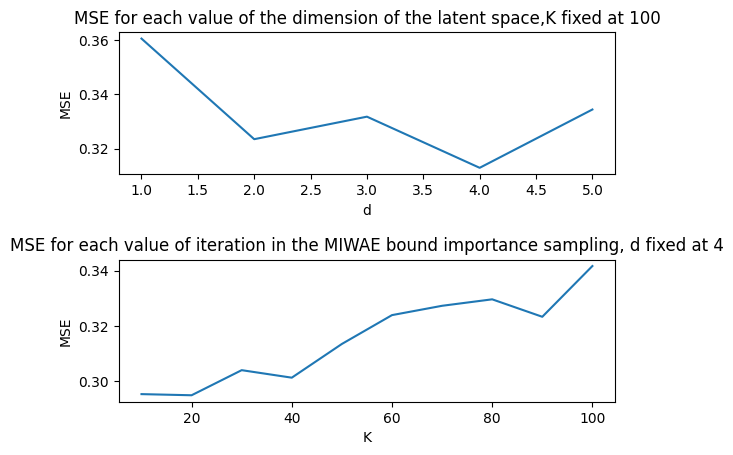

In [166]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,100,10),full_data=X_1,miss_data=opti_test,mask=mask_test)

The minimum mse value is obtained for a number of trees in the forest of : 16.0


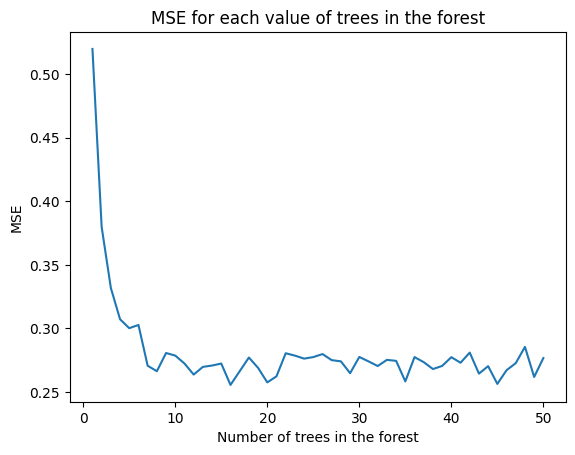

In [167]:
optimize_RF_param(n_est_array=np.linspace(1,50,50),full_data=X_1,miss_data=opti_test,mask=mask_test)

In [168]:

mech_1=["mcar","mar","mnar"]
meth_1=["MIWAE","RF","MIDA","MEAN"]
prop_1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_1=10
M_1=1000
## MIDA
la_1= [64,64,64] 
lr_1=0.0017
in_1=0.8
trb_1=32
tr_1=100
MIDA_1=[la_1,lr_1,in_1,trb_1,seed_1,tr_1]
#MIWAE 
d_1=4
h_1=64
K_1=20
tr_M_1=100
MIWAE_1=[d_1,h_1,K_1,tr_M_1]
# RF
iter_1=10
est_1=16
RF_1=[iter_1,est_1]




In [169]:
## Compare

exp1_res,exp1_boxplot=comparison(full_data=X_1,missing_mecha=mech_1,prop_NA=prop_1,comp_methods=meth_1,nb_simu=sim_1,M=M_1,device=device,Mida_param=MIDA_1,Miwae_param=MIWAE_1,Rf_param=RF_1,save=True)


MCAR
Computation for 10.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 20.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 30.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 40.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 50.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 60.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 70.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 80.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 90.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
MAR
Computation for 10.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 20.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 30.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 40.0 % of NA values
Simulation 1-5 done
Simulation 

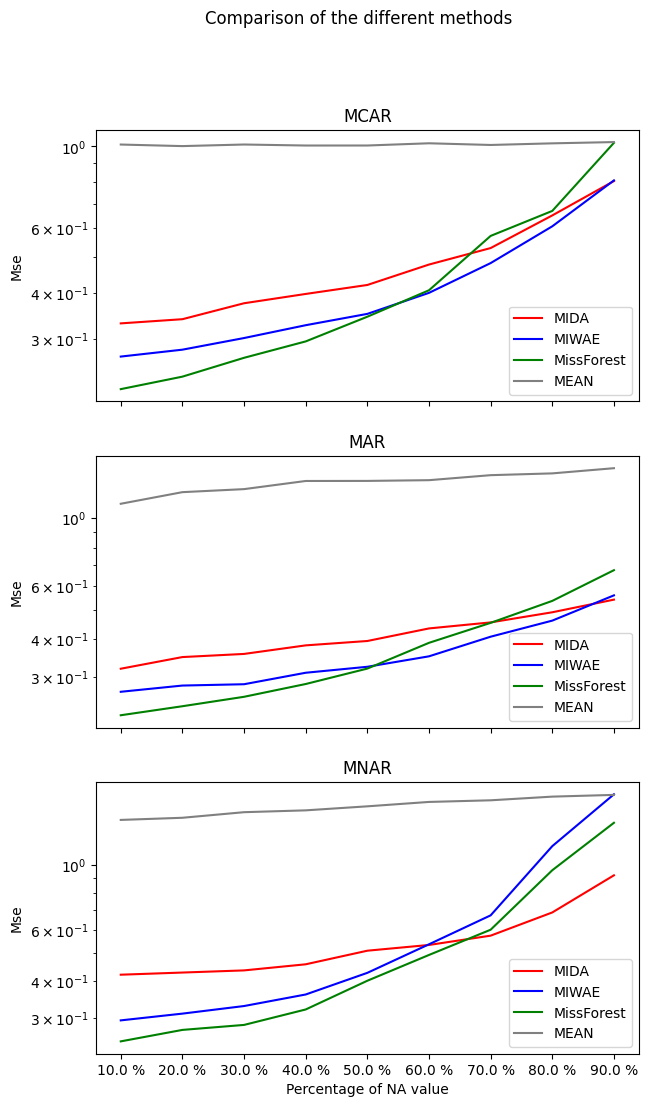

In [190]:
plot_result(results=exp1_res,comp_meth=meth_1,save=True,name="Non_linear_case.pdf")

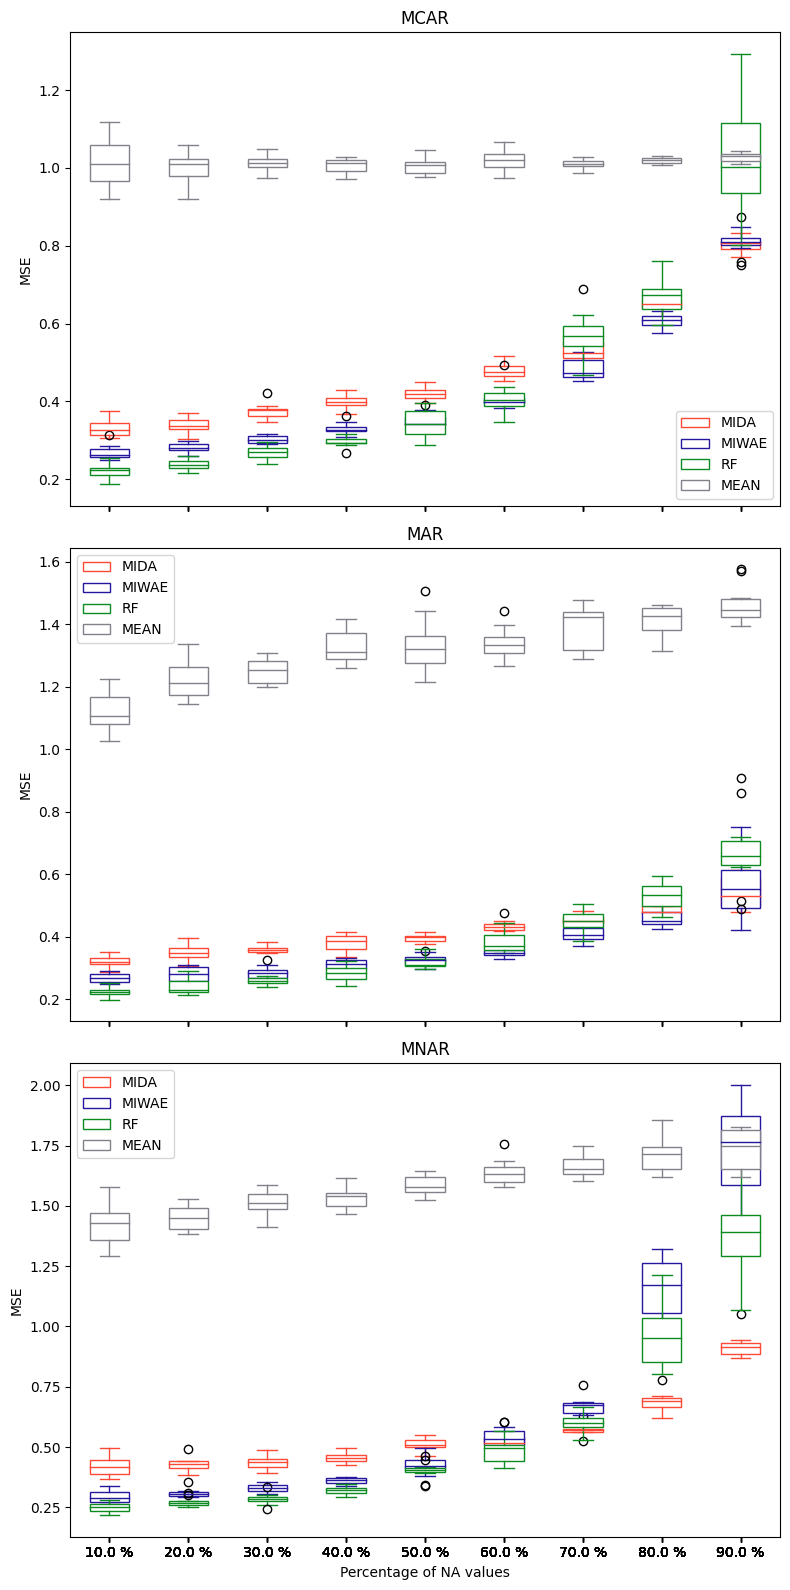

In [283]:
boxplot_results(results=exp1_boxplot,prop_l=prop_1,meth=meth_1,mech=mech_1,save=True,name="boxplot_non_linear_case.pdf")

## Linear case :

In [191]:
seed_2=14
n_2=300
cov_2=8
var_2=0.3
mod_2="linear"
k_2=0.5
mu_2=[150,12]
Sigma_2=np.array([[5,0.5],[0.5,0.9]])
exp_2=pd.DataFrame(create_complete_dataset(seed=seed_2,n=n_2,c=cov_2,modSimu=mod_2,k=k_2,mu=mu_2,Sigma=Sigma_2,noise=var_2))
X_2=(exp_2 - np.mean(exp_2,0))/np.std(exp_2,0)
cor_2=X_2.corr()
print(cor_2)

          0         1         2         3         4         5         6   
0  1.000000  0.985167  0.985924  0.983471  0.183626  0.217529  0.199309  \
1  0.985167  1.000000  0.983911  0.985420  0.171583  0.216262  0.196590   
2  0.985924  0.983911  1.000000  0.984574  0.173564  0.212233  0.191980   
3  0.983471  0.985420  0.984574  1.000000  0.167995  0.212333  0.194125   
4  0.183626  0.171583  0.173564  0.167995  1.000000  0.900116  0.900989   
5  0.217529  0.216262  0.212233  0.212333  0.900116  1.000000  0.911726   
6  0.199309  0.196590  0.191980  0.194125  0.900989  0.911726  1.000000   
7  0.204326  0.195110  0.190409  0.192158  0.908360  0.906404  0.909638   

          7  
0  0.204326  
1  0.195110  
2  0.190409  
3  0.192158  
4  0.908360  
5  0.906404  
6  0.909638  
7  1.000000  


In [192]:
opti_2,mask_2=missing_method(raw_data=X_2,mechanism="mcar",t=0.3)

The minimum mse value is obtained for a learning rate : 0.001


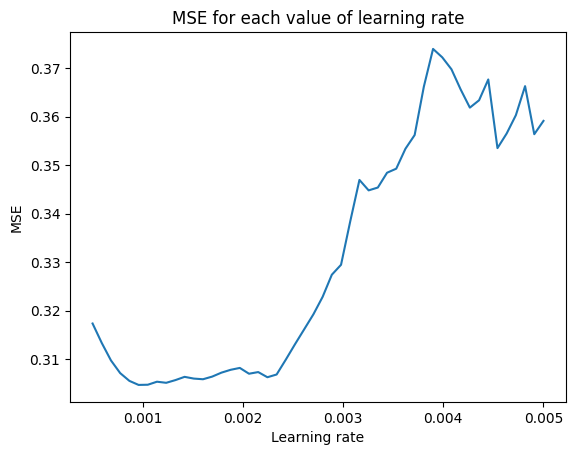

In [193]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0005,50),full_data=X_2,miss_data=opti_2,mask=mask_2)

The minimum mse value is obtained for a dimension of the latent space d: 2 and a number of iteration for the importance sampling of the MIWAE bound construction K :20.0


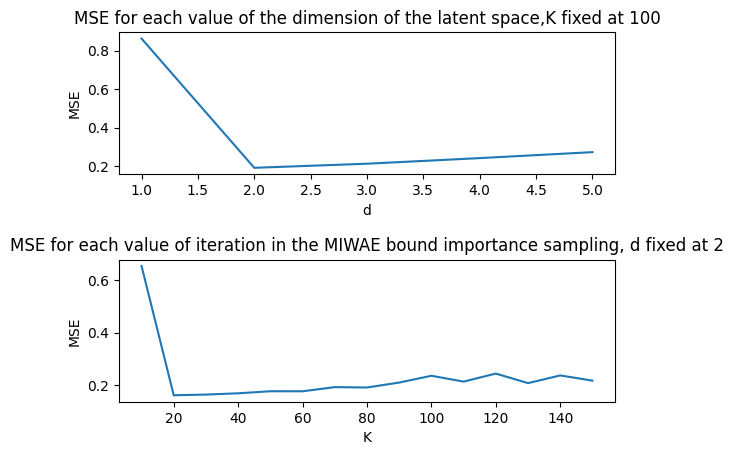

In [194]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,150,15),full_data=X_2,miss_data=opti_2,mask=mask_2)

The minimum mse value is obtained for a number of trees in the forest of : 16.0


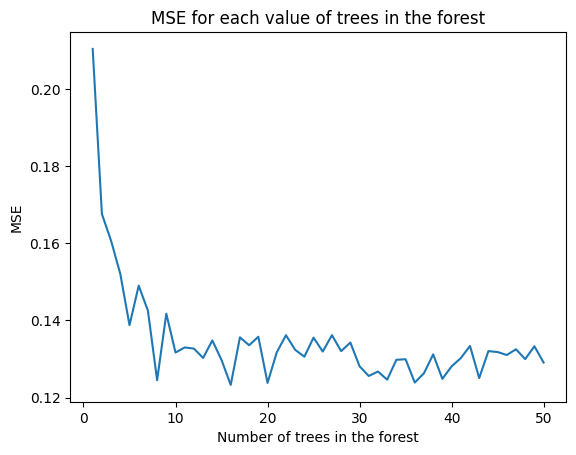

In [195]:
optimize_RF_param(n_est_array=np.linspace(1,50,50),full_data=X_2,miss_data=opti_2,mask=mask_2)

In [197]:
mech_2=["mcar","mar","mnar"]
meth_2=["MIWAE","RF","MIDA","MEAN"]
prop_2=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_2=10
M_2=1000
## MIDA
la_2= [64,64,64] 
lr_2=0.001
in_2=0.8
tr_2=32
tr_2=100
MIDA_2=[la_2,lr_2,in_2,tr_2,seed_2,tr_2]
#MIWAE 
d_2=4
h_2=64
K_2=20
tr_M_2=100
MIWAE_2=[d_2,h_2,K_2,tr_M_2]
# RF
iter_2=10
est_2=16
RF_2=[iter_2,est_2]


In [198]:
exp2_res,exp2_boxplot=comparison(full_data=X_2,missing_mecha=mech_2,prop_NA=prop_2,comp_methods=meth_2,nb_simu=sim_2,M=M_2,device=device,Mida_param=MIDA_2,Miwae_param=MIWAE_2,Rf_param=RF_2,save=True)


MCAR
Computation for 10.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 20.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 30.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 40.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 50.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 60.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 70.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 80.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 90.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
MAR
Computation for 10.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 20.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 30.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 40.0 % of NA values
Simulation 1-5 done
Simulation 

In [199]:
print(exp2_res)

{'MCAR':          10.0 %    20.0 %    30.0 %    40.0 %    50.0 %    60.0 %    70.0 %   
MIWAE  0.157002  0.171042  0.211855  0.270136  0.347380  0.433395  0.598365  \
RF     0.099792  0.105386  0.145725  0.189443  0.294487  0.398325  0.597462   
MIDA   0.300282  0.331866  0.379122  0.416340  0.475367  0.528277  0.619211   
MEAN   0.966960  0.986126  1.004253  1.003319  1.009220  1.012644  1.016331   

         80.0 %    90.0 %  
MIWAE  0.793784  1.055932  
RF     0.834781  1.219670  
MIDA   0.722017  0.936277  
MEAN   1.015660  1.037633  , 'MAR':          10.0 %    20.0 %    30.0 %    40.0 %    50.0 %    60.0 %    70.0 %   
MIWAE  0.144928  0.158889  0.191173  0.232041  0.295395  0.357048  0.501938  \
RF     0.100471  0.115391  0.133137  0.162515  0.243204  0.290868  0.444573   
MIDA   0.403328  0.385486  0.390920  0.398878  0.453651  0.453401  0.499950   
MEAN   1.339826  1.248035  1.216676  1.209590  1.198958  1.228047  1.228551   

         80.0 %    90.0 %  
MIWAE  0.781220  0.8725

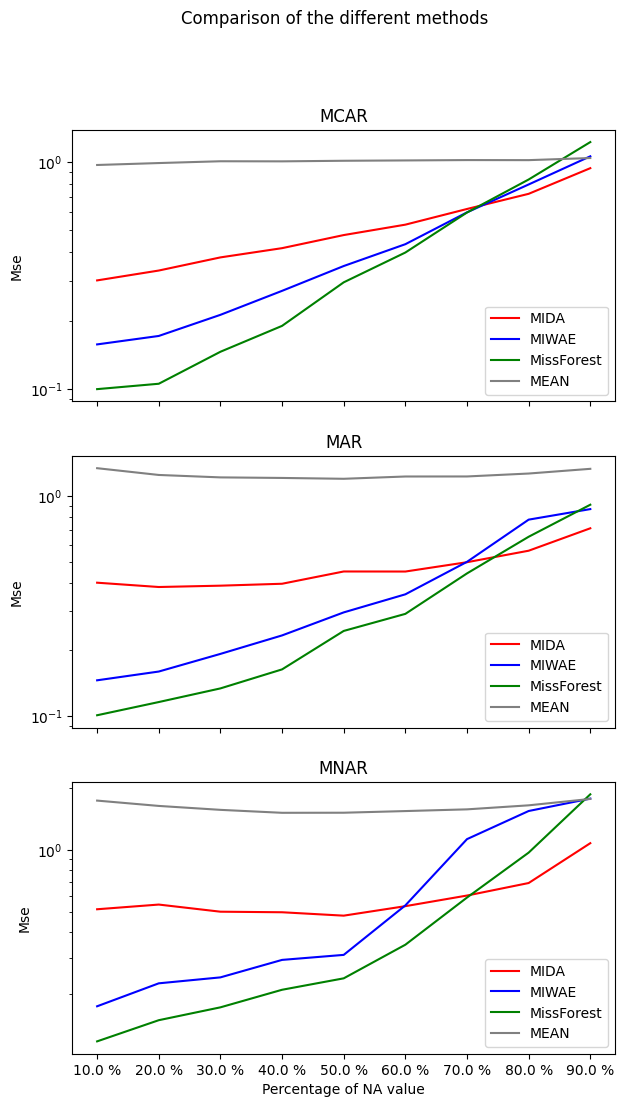

In [200]:
plot_result(results=exp2_res,comp_meth=meth_2,save=True,name="Linear_case.pdf")

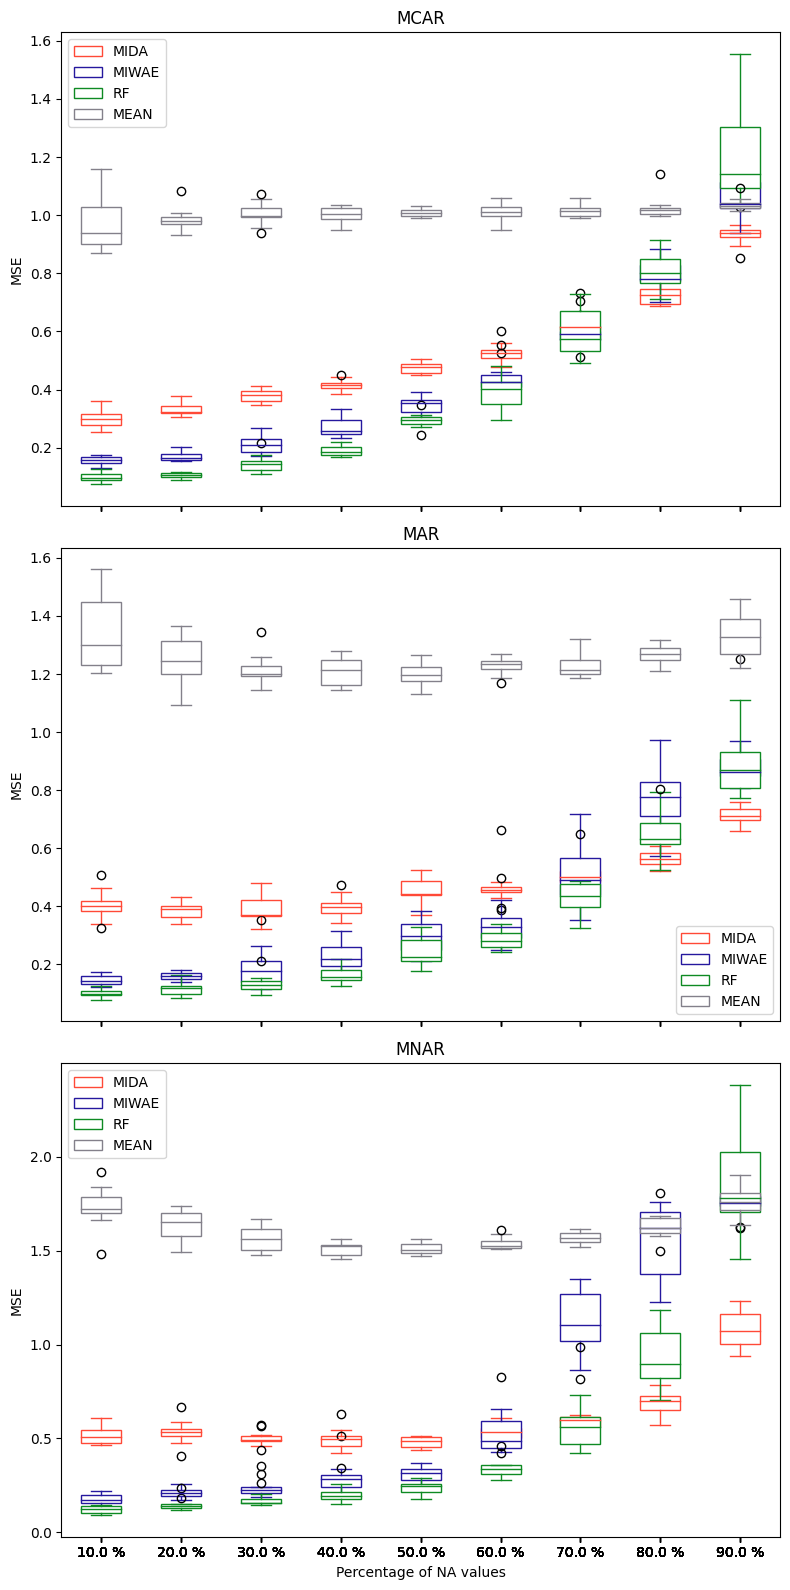

In [220]:
boxplot_results(results=exp2_boxplot,prop_l=prop_2,meth=meth_2,mech=mech_2,save=True,name="boxplot_linear_case.pdf")

## Non standardization of the data

In [11]:
seed_3=14
n_3=300
cov_3=8
var_3=0.4
mod_3="linear"
k_3=0.4
mu_3=[22,0]
Sigma_3=np.array([[0.8,0.4],[0.4,71]])
X_3=pd.DataFrame(create_complete_dataset(seed=seed_3,n=n_3,c=cov_3,modSimu=mod_3,k=k_3,mu=mu_3,Sigma=Sigma_3,noise=var_3))
cor_3=X_3.corr()
print(cor_3)


          0         1         2         3         4         5         6   
0  1.000000  0.764320  0.774463  0.142512  0.145183  0.145445  0.136932  \
1  0.764320  1.000000  0.786954  0.127503  0.125737  0.132198  0.125072   
2  0.774463  0.786954  1.000000  0.179597  0.181167  0.183230  0.176577   
3  0.142512  0.127503  0.179597  1.000000  0.997468  0.997735  0.997274   
4  0.145183  0.125737  0.181167  0.997468  1.000000  0.997391  0.997464   
5  0.145445  0.132198  0.183230  0.997735  0.997391  1.000000  0.997771   
6  0.136932  0.125072  0.176577  0.997274  0.997464  0.997771  1.000000   
7  0.142579  0.127395  0.182340  0.997454  0.997546  0.997736  0.997510   

          7  
0  0.142579  
1  0.127395  
2  0.182340  
3  0.997454  
4  0.997546  
5  0.997736  
6  0.997510  
7  1.000000  


In [12]:
opti_3,mask_3=missing_method(raw_data=X_3,mechanism="mcar",t=0.3)

In [13]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0005,50),full_data=X_3,miss_data=opti_3,mask=mask_3)

NameError: name 'optimize_MIDA_param' is not defined

The minimum mse value is obtained for a dimension of the latent space d: 3 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


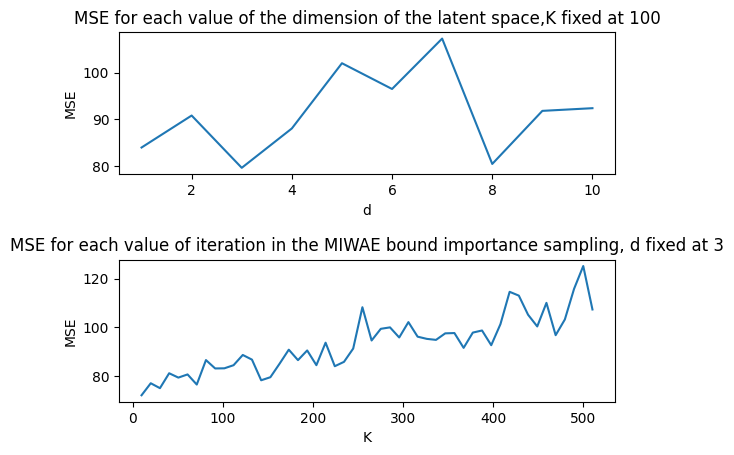

In [213]:
optimize_MIWAE_param(d_array=np.linspace(1,10,10),K_array=np.linspace(10,510,50),full_data=X_3,miss_data=opti_3,mask=mask_3)

The minimum mse value is obtained for a number of trees in the forest of : 25.10204081632653


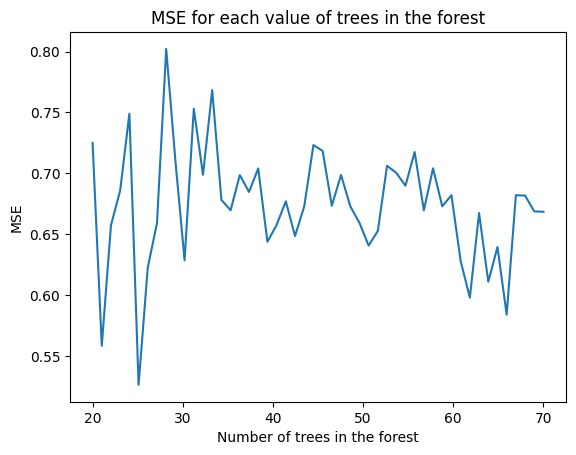

In [214]:
optimize_RF_param(n_est_array=np.linspace(20,70,50),full_data=X_3,miss_data=opti_3,mask=mask_3)

In [14]:
mech_3=["mcar","mar","mnar"]
meth_3=["MIWAE","RF","MIDA","MEAN"]
prop_3=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_3=10
M_3=1000
## MIDA
la_3= [64,64,64] 
lr_3=0.0038
in_3=0.8
tr_3=32
tr_3=100
MIDA_3=[la_3,lr_3,in_3,tr_3,seed_3,tr_3]
#MIWAE 
d_3=3
h_3=64
K_3=10
tr_M_3=100
MIWAE_3=[d_3,h_3,K_3,tr_M_3]
# RF
iter_3=10
est_3=25
RF_3=[iter_3,est_3]


In [15]:
exp3_res,exp3_boxplot=comparison(full_data=X_3,missing_mecha=mech_3,prop_NA=prop_3,comp_methods=meth_3,nb_simu=sim_3,M=M_3,device=device,Mida_param=MIDA_3,Miwae_param=MIWAE_3,Rf_param=RF_3,save=True)


NameError: name 'comparison' is not defined

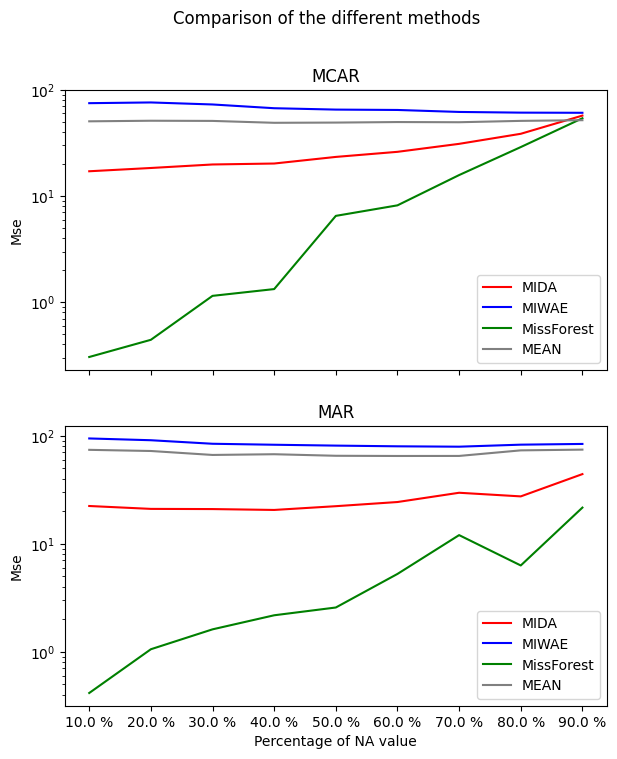

In [282]:
plot_result(results=exp3_res,comp_meth=meth_3,save=True,name="non_standardization.pdf")

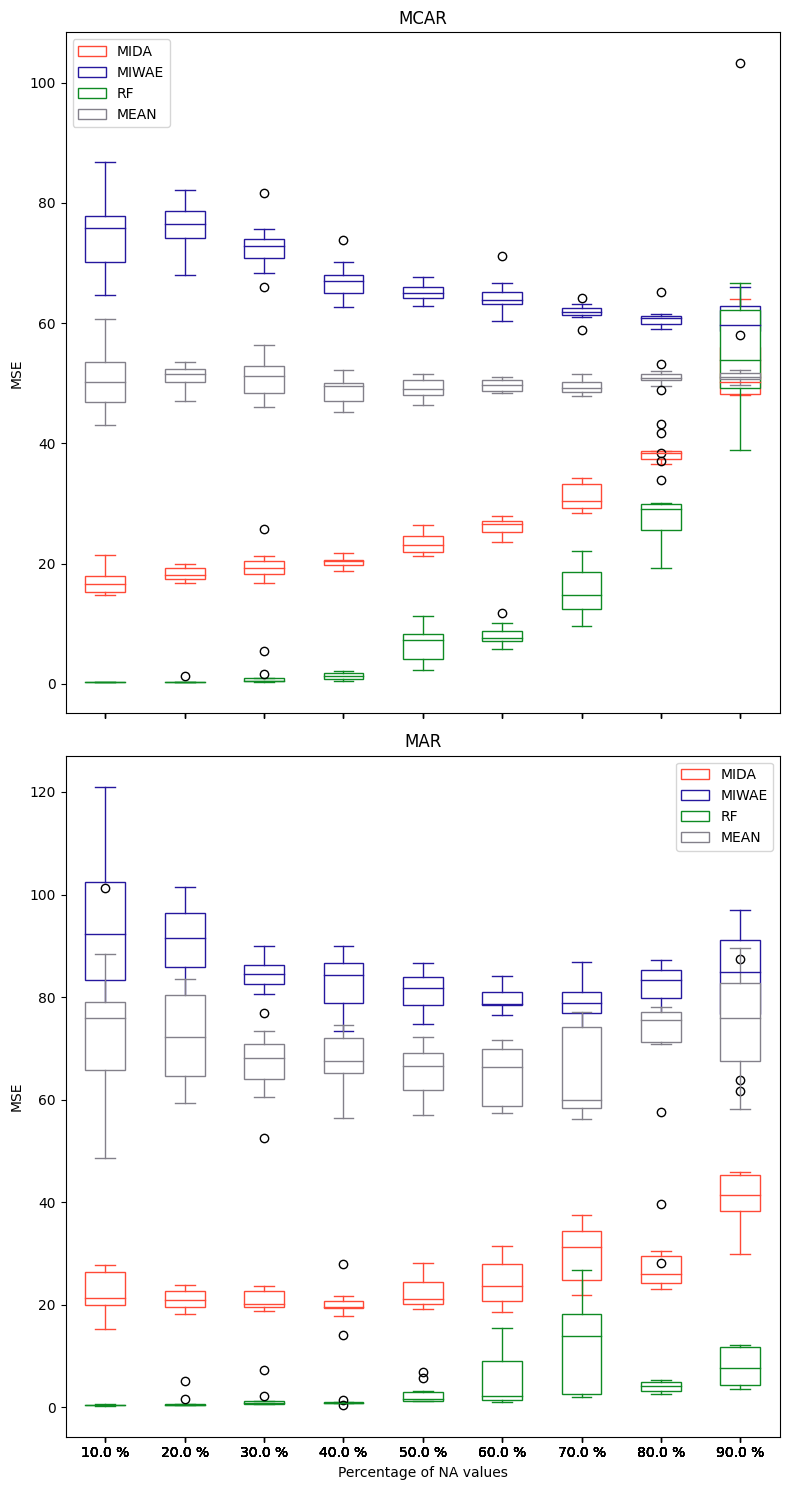

In [281]:
boxplot_results(results=exp3_boxplot,prop_l=prop_3,meth=meth_3,mech=mech_3,save=True,name="boxplot_non_standardization.pdf")

## On a real word dataset

In [10]:
from sklearn.datasets import load_breast_cancer
data_tmp = load_breast_cancer()
data=pd.DataFrame(data_tmp.data)


In [11]:
data_std=(data-np.mean(data,0))/np.std(data,0)

In [36]:
opti_4,mask_4=missing_method(raw_data=data_std,mechanism="mar",t=0.3)

The minimum mse value is obtained for a learning rate : 0.0011


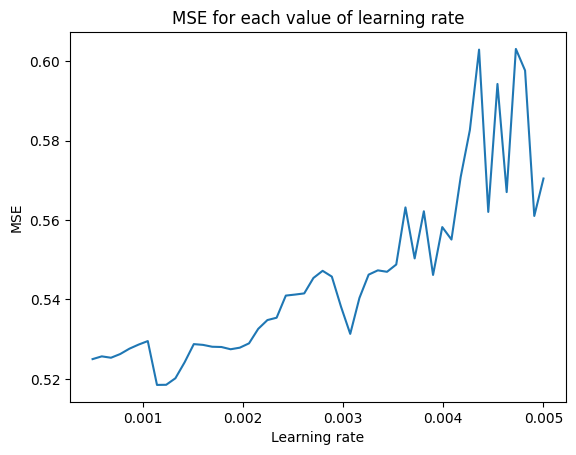

In [40]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0005,50),full_data=data_std,miss_data=opti_4,mask=mask_4)

The minimum mse value is obtained for a dimension of the latent space d: 7 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


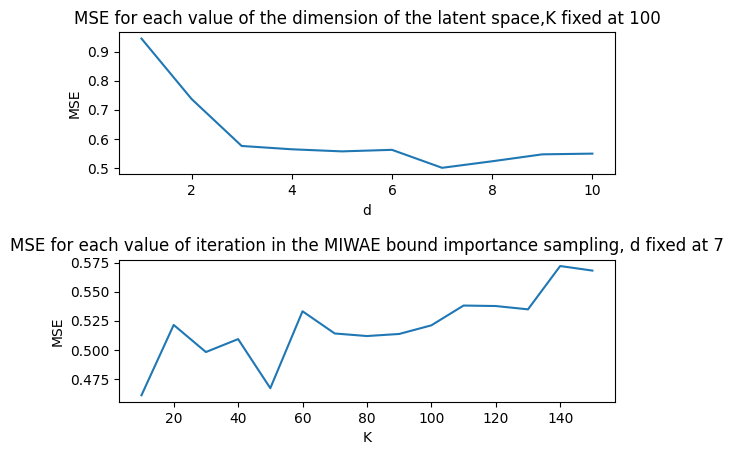

In [43]:
optimize_MIWAE_param(d_array=np.linspace(1,10,10),K_array=np.linspace(10,150,15),full_data=data_std,miss_data=opti_4,mask=mask_4)

The minimum mse value is obtained for a number of trees in the forest of : 48.0


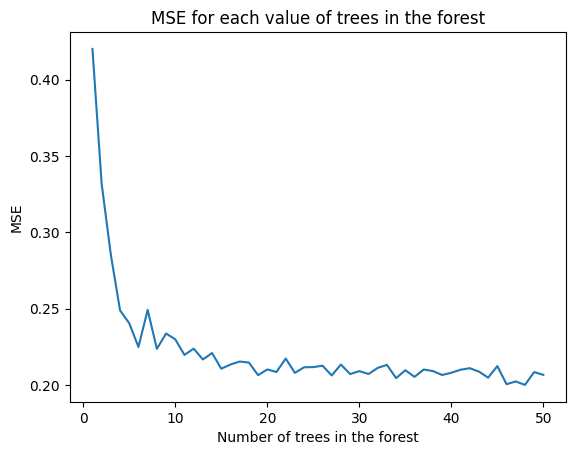

In [42]:
optimize_RF_param(n_est_array=np.linspace(1,50,50),full_data=data_std,miss_data=opti_4,mask=mask_4)

In [12]:
seed_4=756
mech_4=["mcar","mar","mnar"]
meth_4=["MIWAE","RF","MIDA","MEAN"]
prop_4=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_4=10
M_4=1000
## MIDA
la_4= [64,64,64] 
lr_4=0.0011
in_4=0.8
tr_4=32
tr_4=100
MIDA_4=[la_4,lr_4,in_4,tr_4,seed_4,tr_4]
#MIWAE 
d_4=7
h_4=64
K_4=10
tr_M_4=100
MIWAE_4=[d_4,h_4,K_4,tr_M_4]
# RF
iter_4=10
est_4=48
RF_4=[iter_4,est_4]


In [13]:
exp4_res,exp4_boxplot=comparison(full_data=data_std,missing_mecha=mech_4,prop_NA=prop_4,comp_methods=meth_4,nb_simu=sim_4,M=M_4,device=device,Mida_param=MIDA_4,Miwae_param=MIWAE_4,Rf_param=RF_4,save=False)


MCAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.

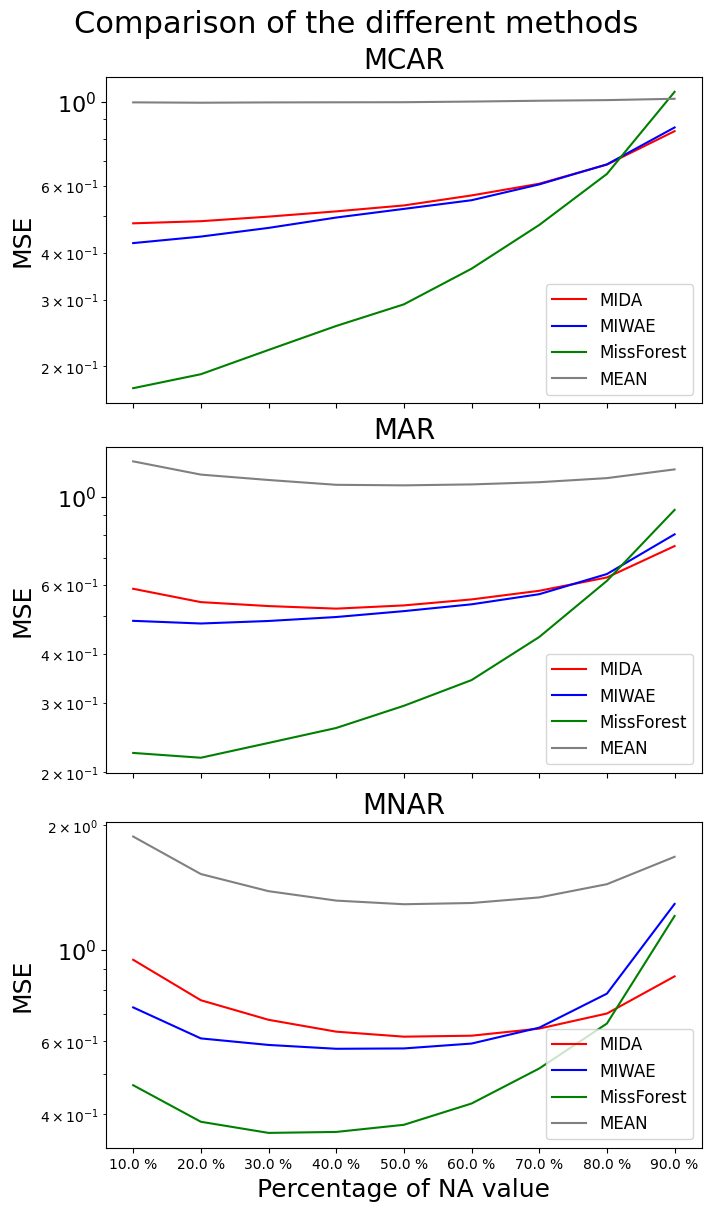

In [15]:
plot_result(results=exp4_res,comp_meth=meth_4,save=True,name="breast_cancer.png")